# Toyota Corolla Case Study
#### C. Griffith - BUSI 650 Summer 2022

##### **Objective** 

> The file _ToyotaCorolla.csv_ contains data on used cars (Toyota Corolla) on sale during late summer of 2004 in the Netherlands. It has 1436 records containing details on 38 attributes, including Price, Age, Kilometers, HP, and other specifications. The goal is to predict the price of a used Toyota Corolla based on its specifications. 

## ***Import packages and define functions.***

In [ ]:
# import packages
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline 
sns.set(color_codes=True)
sns.set(style="darkgrid")

In [ ]:
# function to compute adjusted R-squared - Source: Rakesh Mittal Ph.D
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100

# function to compute different metrics to check performance of a regression model
def model_performance_regression(name, num_features, model, predictors, target):
    
    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Model Set": name,
            "Features": num_features,
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

## ***Read the dataset into pandas dataframes.***

In [ ]:
# Authorization of GDrive
drive.mount('/content/drive/')

# Change working directory location to datasets
%cd /content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets

# Load dataset
toyota_corolla_df = pd.read_csv('ToyotaCorolla.csv')

Mounted at /content/drive/
/content/drive/MyDrive/Data_Science/BUSI_650_Business_Analytics_Decision_Making/Data_Sets


## ***Tasks***

### **Carry out a brief EDA of the data, and prepare it for modeling**

In [ ]:
# shape
toyota_corolla_df.shape

(1436, 39)

**Comment**: The dataset has 1436 records, 38 features and 1 outcome variable

---

In [ ]:
toyota_corolla_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 39 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 1436 non-null   int64 
 1   Model              1436 non-null   object
 2   Price              1436 non-null   int64 
 3   Age_08_04          1436 non-null   int64 
 4   Mfg_Month          1436 non-null   int64 
 5   Mfg_Year           1436 non-null   int64 
 6   KM                 1436 non-null   int64 
 7   Fuel_Type          1436 non-null   object
 8   HP                 1436 non-null   int64 
 9   Met_Color          1436 non-null   int64 
 10  Color              1436 non-null   object
 11  Automatic          1436 non-null   int64 
 12  CC                 1436 non-null   int64 
 13  Doors              1436 non-null   int64 
 14  Cylinders          1436 non-null   int64 
 15  Gears              1436 non-null   int64 
 16  Quarterly_Tax      1436 non-null   int64 


**Comment**: 36 out of 39 features are integer types.
> ***Model, Fuel_Type, and Color*** are Categorical Features

---

In [ ]:
# filter dataset to use only required features based on assignment
toyota_corolla_df = toyota_corolla_df[['Age_08_04', 'KM', 'Fuel_Type', 
                                       'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 
                                       'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 
                                       'Automatic_airco', 'CD_Player', 'Powered_Windows', 
                                       'Sport_Model', 'Tow_Bar', 'Price']]

In [ ]:
# show number of null values in each column
toyota_corolla_df.isnull().sum()

Age_08_04           0
KM                  0
Fuel_Type           0
HP                  0
Automatic           0
Doors               0
Quarterly_Tax       0
Mfr_Guarantee       0
Guarantee_Period    0
Airco               0
Automatic_airco     0
CD_Player           0
Powered_Windows     0
Sport_Model         0
Tow_Bar             0
Price               0
dtype: int64

**Comment**: None of the records have null values for the required 15 features and 1 outcome variable

---

In [ ]:
# show number of unique values in each column
toyota_corolla_df.nunique()

Age_08_04             77
KM                  1263
Fuel_Type              3
HP                    12
Automatic              2
Doors                  4
Quarterly_Tax         13
Mfr_Guarantee          2
Guarantee_Period       9
Airco                  2
Automatic_airco        2
CD_Player              2
Powered_Windows        2
Sport_Model            2
Tow_Bar                2
Price                236
dtype: int64

In [ ]:
# identify categories for Fule_Type feature
toyota_corolla_df['Fuel_Type'].unique()

array(['Diesel', 'Petrol', 'CNG'], dtype=object)

**Comment**: Fuel_Type feature can be converted from Categorical to Int using three (3) dummy variables

---

In [ ]:
# create dummy variables for Fuel_Type
toyota_corolla_df = pd.get_dummies(toyota_corolla_df, columns=['Fuel_Type'])
toyota_corolla_df.shape

(1436, 18)

In [ ]:
# drop one feature from Fuel_Type dummy variable set
toyota_corolla_df = toyota_corolla_df.drop(columns=['Fuel_Type_CNG'], axis=1)
toyota_corolla_df.shape

(1436, 17)

**Comment**: After removing one dummy variable, there are now 16 features and 1 outcome variable in this dataset

---

In [ ]:
# show general stats summary of features
toyota_corolla_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age_08_04,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
KM,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
HP,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
Automatic,1436.0,0.055710,0.229441,0.0,0.0,0.0,0.00,1.0
Doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
Quarterly_Tax,1436.0,87.122563,41.128611,19.0,69.0,85.0,85.00,283.0
Mfr_Guarantee,1436.0,0.409471,0.491907,0.0,0.0,0.0,1.00,1.0
Guarantee_Period,1436.0,3.815460,3.011025,3.0,3.0,3.0,3.00,36.0
Airco,1436.0,0.508357,0.500104,0.0,0.0,1.0,1.00,1.0
Automatic_airco,1436.0,0.056407,0.230786,0.0,0.0,0.0,0.00,1.0


**Comment**: All features are integers with a large range of values for the features KM, Age, HP, Quarterly_Tax and the outcome variable Price

---

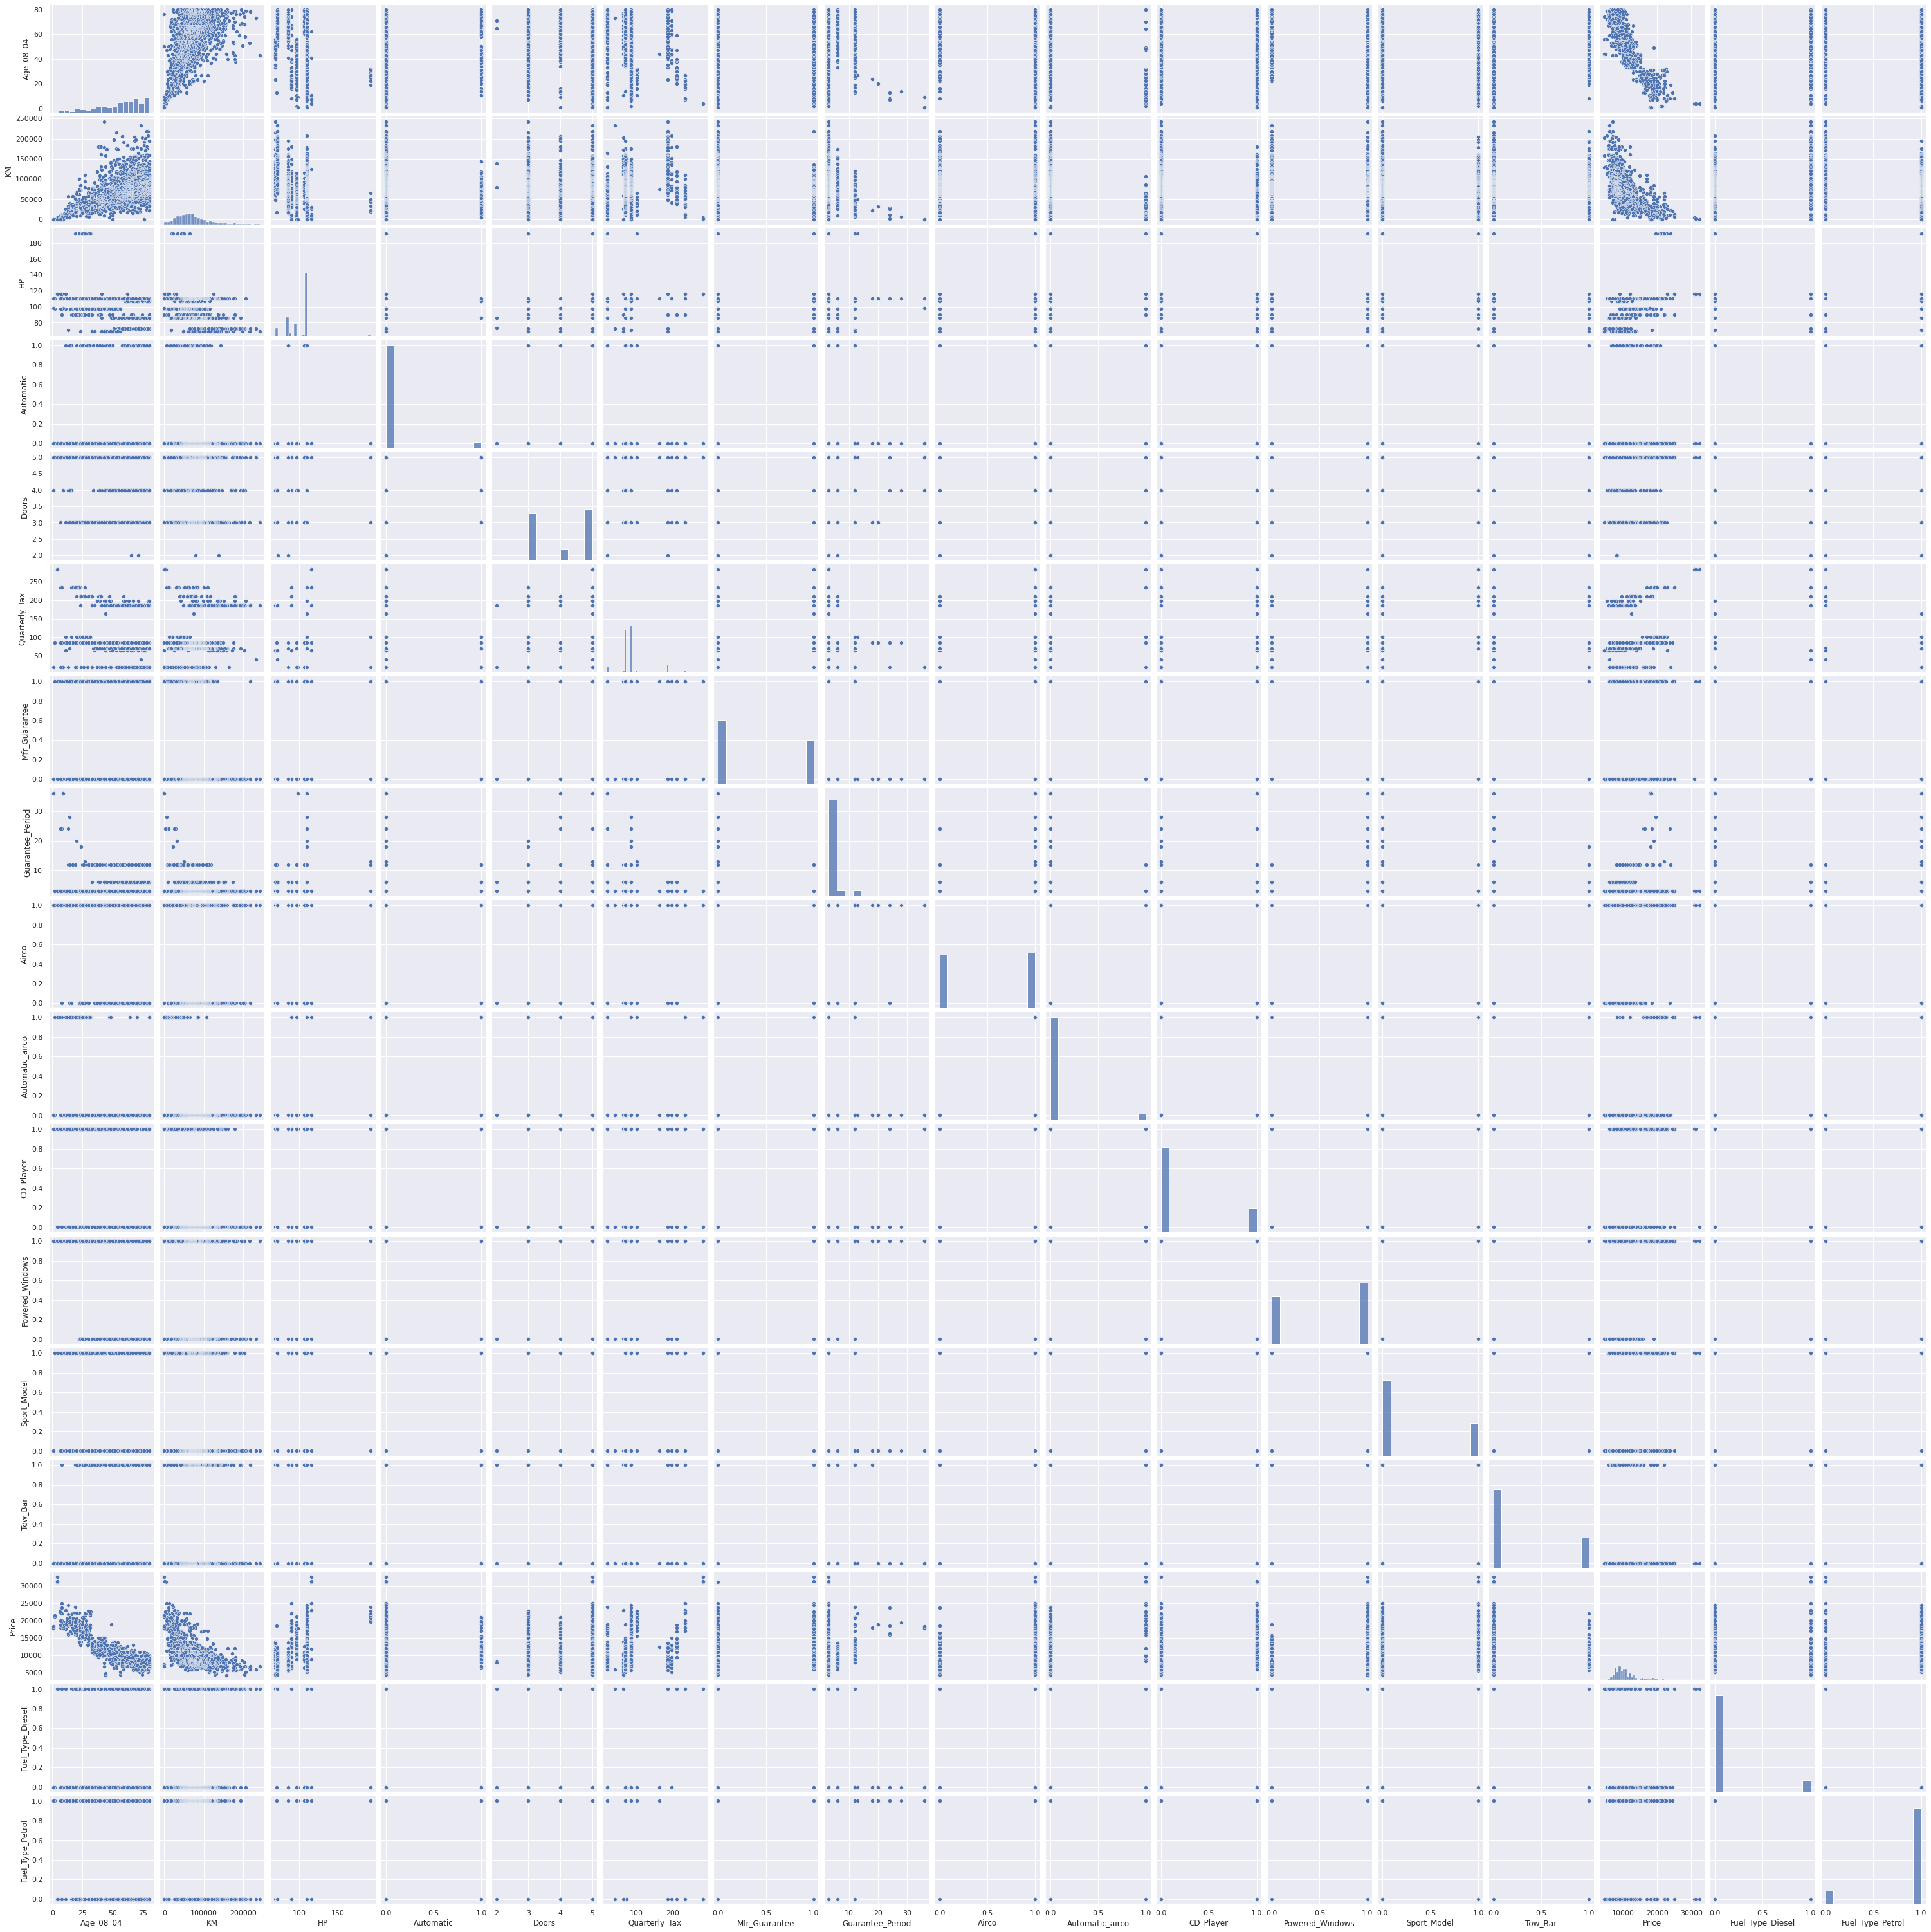

In [ ]:
# create scatter plots between features 
sns.pairplot(toyota_corolla_df);

**Comment**: It appears that Price has a negative correlation with Age and KM. KM and Age have positive correlations between them. All other features appear to have little to no correlation between each other. Majority of the features have a positive correlation with *Price*.

---

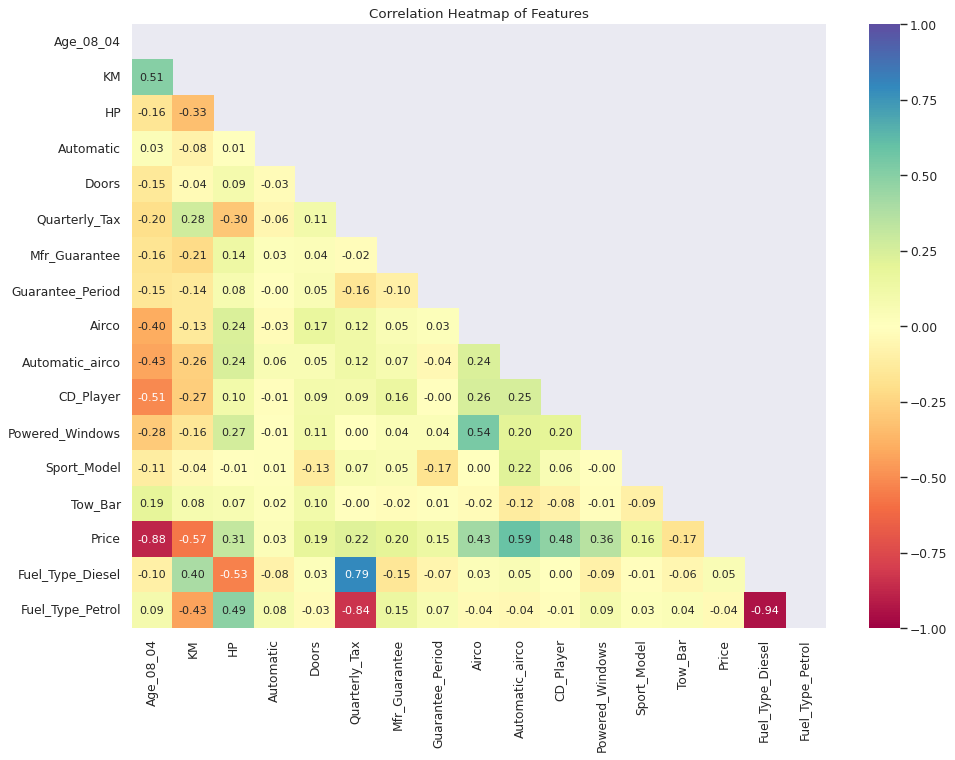

In [ ]:
# create correlation map between features except for State and Year
figure(figsize=(14, 10), dpi=80)
corr = toyota_corolla_df.corr()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral", mask = np.triu(corr)).set(title = "Correlation Heatmap of Features");

**Comment**: As previously noted in the pairplots, the correlation matrix further supports that there is little to no correlation between most of the features. Majority of the features have a positive correlation with *Price*.

---

#### ***Observation***

> The dataset was transformed to only include the feature revelant to this assignment. The categorical feature *Fuel_Type* was dummy coded to be properly used in the linear regression model. Is there little to no correlation between most of the features. *KM and Age* appears to have the most negative correlation with each other and with the outcome variable *Price*. Majority of the features have a positive correlation with *Price*.

---

### **Split the data into training (70%), and test (30%) datasets. Run a multiple linear regression with the outcome variable Price and predictor variables Age_08_04, KM, Fuel_Type, HP, Automatic, Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar.**

In [ ]:
# Separating the target variable (Price) and the other 16 predictor variables
X = toyota_corolla_df.drop(['Price'], axis=1) 
y = toyota_corolla_df['Price']

# split data using 70/30 percentage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)

In [ ]:
car_linreg = LinearRegression() # specifying the algorthm to use
car_linreg.fit(X_train, y_train) # Fitting the train data on the algorithm
pred = car_linreg.predict(X_test) # generating the predicted values

In [ ]:
# The intercept
print('Interccept:', car_linreg.intercept_)

# The coefficients
print('\nCoefficients')
coefficients_data = {'feature': X.columns, 'coefficients': car_linreg.coef_}
coefficients_df = pd.DataFrame(coefficients_data)

pd.options.display.float_format = '{:.2f}'.format
coefficients_df

Interccept: 10025.571208214584

Coefficients


,feature,coefficients
0,Age_08_04,-110.76
1,KM,-0.02
2,HP,35.19
3,Automatic,460.21
4,Doors,117.63
5,Quarterly_Tax,16.57
6,Mfr_Guarantee,138.34
7,Guarantee_Period,85.83
8,Airco,144.33
9,Automatic_airco,3293.95


#### ***Observation***

> As expected from on the EDA, Age and KM have negative coefficients; however, KM appears to be very close to zero. Suprisingly Tow_Bar also has a negative coefficient. The remaining features have positive coefficients which is also supported by the EDA. 

---

### **Compare the performance of Train and Test data sets**

In [ ]:
# create price dataframe of train and test sets
price_data = {'train': y_train, 'test': y_test}
price_df = pd.DataFrame(price_data)

print('Price Stats for Train and Test Sets')
price_df.describe()

Price Stats for Train and Test Sets


,train,test
count,1005.00,431.00
mean,10633.18,10958.51
std,3612.83,3653.78
min,4350.00,5150.00
25%,8400.00,8500.00
50%,9850.00,9950.00
75%,11750.00,12475.00
max,32500.00,24950.00


In [ ]:
# checking model performance on train set (seen 70% data)
train_perf = model_performance_regression('Train Set',len(X.columns), car_linreg, X_train, y_train)

# checking model performance on test set (seen 30% data)
test_perf = model_performance_regression('Test Set',len(X.columns), car_linreg, X_test, y_test)

# create dataframe with both perf stats
compare_perf = pd.concat([train_perf, test_perf], ignore_index = True)

print("Performance Comparison\n")
compare_perf

Performance Comparison



,Model Set,Features,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train Set,16,1237.34,918.41,0.88,0.88,9.16
1,Test Set,16,1144.35,893.01,0.90,0.90,8.63


#### ***Observation***

> With the 16 features ( 2 of which are the results of a dummy coding), the model performed compariable between the the training and test sets. RMSE and MAE are both reasonable considering the range and values of the Price outcome variable. These errors are also reflective in the MAPE which, at around 9% for the both train and test sets, yields favorable predictive results.

---

### **5. Graph the first 25 records, showing actual price and predicted price of used Toyota Corolla**

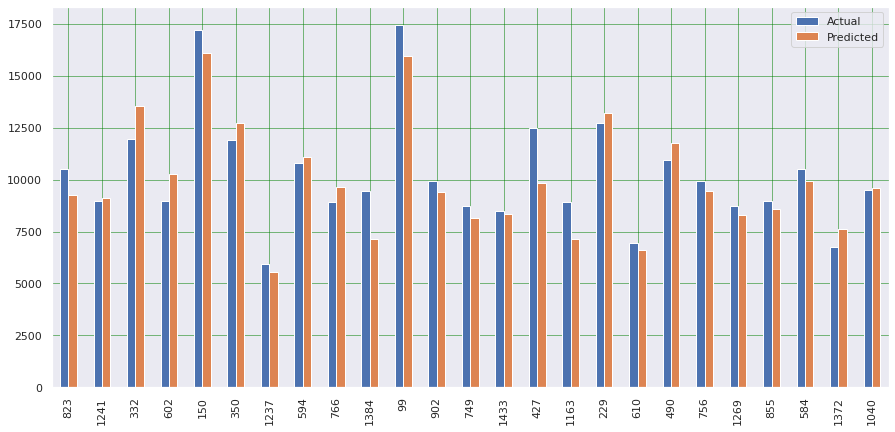

In [ ]:
df_pred_test = pd.DataFrame({"Actual": y_test, "Predicted": pred}) # saving the values to a data frame
df1 = df_pred_test.head(25) # store first 25 records
df1.plot(kind="bar", figsize=(15, 7)) # plot bar graph
plt.grid(which="major", linestyle="-", linewidth="0.5", color="green"); # adjust figure

#### ***Observation***

> The difference between the Actual and Predicted Prices for the first 25 records are inline with the RMSE, MAE and MAPE metrics. 

---

### ***Further Analysis***
> **Door & Guarantee_Period Features can be converted using Dummy Variables then repeating the Linear Regression Model could produce better results**

In [ ]:
# Load dataset
toyota_corolla_df = pd.read_csv('ToyotaCorolla.csv')

# filter dataset to use only required features
toyota_corolla_df = toyota_corolla_df[['Age_08_04', 'KM', 'Fuel_Type', 
                                       'HP', 'Automatic', 'Doors', 'Quarterly_Tax', 
                                       'Mfr_Guarantee', 'Guarantee_Period', 'Airco', 
                                       'Automatic_airco', 'CD_Player', 'Powered_Windows', 
                                       'Sport_Model', 'Tow_Bar', 'Price']]

In [ ]:
# show unique values of Door
toyota_corolla_df.Doors.unique()

array([3, 5, 4, 2])

In [ ]:
# show unique values of Guarantee_Period
toyota_corolla_df.Guarantee_Period.unique()

array([ 3, 12, 18, 13, 20, 24, 28, 36,  6])

**Comment**: Although these values are close to one another, the differences between these integers could skew the model. Hence, dummy coding these features  may produce better metrics.

---

In [ ]:
# # create dummy variables for Fuel_Type, Doors and Guarantee_Period
toyota_corolla_df = pd.get_dummies(toyota_corolla_df, columns=['Fuel_Type'])
toyota_corolla_df = pd.get_dummies(toyota_corolla_df, columns=['Doors']) 
toyota_corolla_df = pd.get_dummies(toyota_corolla_df, columns=['Guarantee_Period']) 

In [ ]:
# drop one feature each from the dummy variable set
toyota_corolla_df = toyota_corolla_df.drop(columns=['Fuel_Type_CNG', 'Doors_5', 'Guarantee_Period_36'])

In [ ]:
# Separating the target variable (Price) and the other 8 predictor variables
X = toyota_corolla_df.drop(['Price'], axis=1) 
y = toyota_corolla_df['Price']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Age_08_04            1436 non-null   int64
 1   KM                   1436 non-null   int64
 2   HP                   1436 non-null   int64
 3   Automatic            1436 non-null   int64
 4   Quarterly_Tax        1436 non-null   int64
 5   Mfr_Guarantee        1436 non-null   int64
 6   Airco                1436 non-null   int64
 7   Automatic_airco      1436 non-null   int64
 8   CD_Player            1436 non-null   int64
 9   Powered_Windows      1436 non-null   int64
 10  Sport_Model          1436 non-null   int64
 11  Tow_Bar              1436 non-null   int64
 12  Fuel_Type_Diesel     1436 non-null   uint8
 13  Fuel_Type_Petrol     1436 non-null   uint8
 14  Doors_2              1436 non-null   uint8
 15  Doors_3              1436 non-null   uint8
 16  Doors_4              143

**Comment**: There are now 25 features after dummy coding.

---

In [ ]:
# split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3)

In [ ]:
car_linreg = LinearRegression() # specifying the algorthm to use
car_linreg.fit(X_train, y_train) # Fitting the train data on the algorithm
pred = car_linreg.predict(X_test) # generating the predicted values

In [ ]:
# The intercept
print('Interccept:', car_linreg.intercept_)

# The coefficients
print('\nCoefficients')
intercept_data = {'feature': X.columns, 'intercept': car_linreg.coef_}
intercept_df = pd.DataFrame(intercept_data)

pd.options.display.float_format = '{:.5f}'.format
intercept_df

Interccept: 12380.418597012524

Coefficients


,feature,intercept
0,Age_08_04,-109.75626
1,KM,-0.01800
2,HP,32.95757
3,Automatic,486.87430
4,Quarterly_Tax,15.91714
5,Mfr_Guarantee,189.81889
6,Airco,166.87068
7,Automatic_airco,3363.77288
8,CD_Player,244.96147
9,Powered_Windows,450.12581


**Comment**: The additional 9 features from the dummy coding produced a mixture between negative and positive coefficients

---

In [ ]:
# create price dataframe of train and test sets
price_data = {'train': y_train, 'test': y_test}
price_df = pd.DataFrame(price_data)

print('Price Stats for Train and Test Sets')
price_df.describe()

Price Stats for Train and Test Sets


,train,test
count,1005.00000,431.00000
mean,10633.18010,10958.51044
std,3612.83092,3653.78379
min,4350.00000,5150.00000
25%,8400.00000,8500.00000
50%,9850.00000,9950.00000
75%,11750.00000,12475.00000
max,32500.00000,24950.00000


In [ ]:
# checking model performance on train set (seen 70% data)
train_perf = model_performance_regression('Train Set',len(X.columns), car_linreg, X_train, y_train)

# checking model performance on test set (seen 30% data)
test_perf = model_performance_regression('Test Set',len(X.columns), car_linreg, X_test, y_test)

# create dataframe with both perf stats from 16 and 25 feature sets
compare_perf2 = pd.concat([compare_perf, train_perf, test_perf], ignore_index = True)

print("Performance Comparison\n")
compare_perf2

Performance Comparison



,Model Set,Features,RMSE,MAE,R-squared,Adj. R-squared,MAPE
0,Train Set,16,1237.34220,918.40920,0.88259,0.88069,9.16023
1,Test Set,16,1144.34737,893.00650,0.90168,0.89788,8.63359
2,Train Set,25,1220.42162,901.62452,0.88578,0.88286,9.01683
3,Test Set,25,1153.98432,895.34522,0.90002,0.89385,8.61757


#### ***Observation***

> There does not appear to be any significant performance improvement with the additional features. The only thing worth mentioning is the performance metric between the train and test sets with 25 features does appear to be closer in values.

---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=76f0b2db-9aa6-44ae-acc8-8a6f89c1d721' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>